# Ligand-based screening pipeline 

Getting Started   


## Task 1: Data set assembly

**Query [ChEMBL](https://www.ebi.ac.uk/chembl/)** 

* You can either manually query the database for EGFR compounds 
* or do this programmatically. 

Since using the API requires quite some steps, we will walk you through it
* using the TeachOpenCADD material ([T001: Compound data acquisition (ChEMBL)](https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html)), 
* but this could become a part of your pipeline in the future.

Additional material
* [T011 - Querying online api webservices](https://projects.volkamerlab.org/teachopencadd/talktorials/T011_query_online_api_webservices.html)
* [T013 - Query PubChem](https://projects.volkamerlab.org/teachopencadd/talktorials/T013_query_pubchem.html)

## Task 2: Some basic molecular data set computations 

#### Import all necessary libraries

In [1]:
#data handling
import numpy as np
import pandas as pd

# chemistry
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, DataStructs, rdFMCS
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Cluster import Butina

### 2.1: Read and prepare your data set

#### 2.1.1. Read the input data 

Data can be found in a dataframe (`./data/EGFR_compounds_ChEMBL27.csv'`)  that was queried, see T001 tutorial

In [3]:
df=pd.read_csv('./data/EGFR_compounds_ChEMBL27.csv')
df.drop(['IC50','units','Unnamed: 0'], axis=1, inplace=True)
df.head()

,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


#### 2.1.2.Generate molecules and calculate fingerprints

##### We can do that stepwise in lists ...
* Generate molecules ...

In [4]:
mols = []
for entry in df['smiles']:
    mols.append(Chem.MolFromSmiles(entry))

* Calculate fingerprints ...

In [5]:
fps = []
for mol in mols:
    fps.append(GetMorganFingerprintAsBitVect(mol,2))

* and draw them ...

In [7]:
# add names for legend
names= []
for name in df["molecule_chembl_id"]:
    names.append(name)

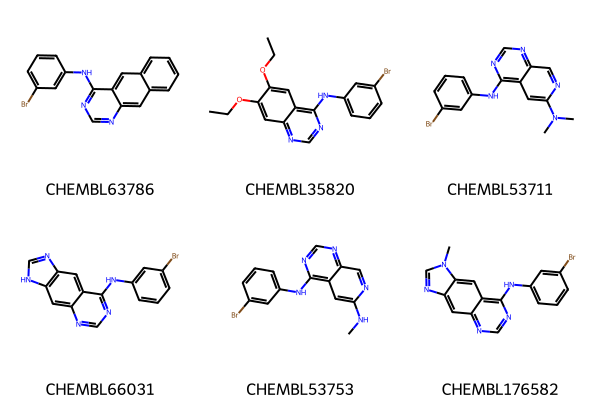

In [8]:
Draw.MolsToGridImage(mols[:6], legends=names[:6])

### And we can do the same directly on the dataframe!! with PandasTools, I prefer
* Add molecule column to dataframe

In [9]:
PandasTools.AddMoleculeColumnToFrame(df,'smiles','molecule',includeFingerprints=True)

* Generate Morgan fingerprints for the compounds and add this column to the dataframe

In [10]:
df['morgan'] = df['molecule'].map(lambda x:GetMorganFingerprintAsBitVect(x,2))

* Draw the molecules

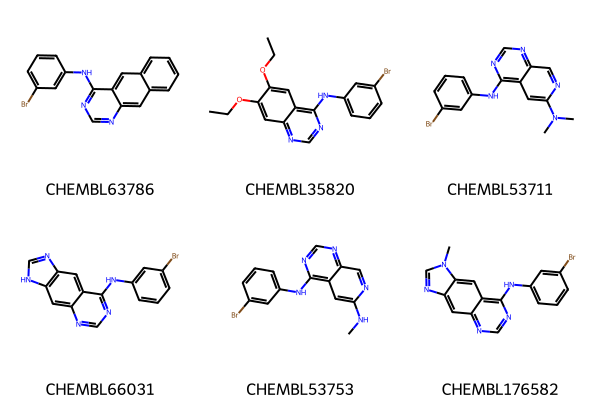

In [11]:
PandasTools.FrameToGridImage(df.head(6), column='molecule', legendsCol='molecule_chembl_id')

In [ ]:
df
# note if alter df molecule column, then must call below func again to visualize molecs
PandasTools.RenderImagesInAllDataFrames(True)

#### 2.1.3 Calculate other information on our dataset

In the same manner we can other information on our dataset (exemplifies some pandas functionality)

* Add a column to the dataframe indicating the activity of the compounds.

    Set the activity cutoff to pIC50 = 6.3 (which corresponds to 500nM), the higher the pIC50 value, the more active the compound. Set the values 1, 0 for active, inactive compounds respectively. 

In [15]:
df['active'] = df['pIC50'].map(lambda x:x>6.3).astype(int)


* Add other molecular descriptors

In [17]:
# ExactMolWt uses most common isotope for each atom (Mass Spec use)
# MolWt uses average weights or the regular distrib of isotopes
df["molWt"] = df["molecule"].apply(Descriptors.MolWt)
df.head()

,molecule_chembl_id,smiles,pIC50,molecule,morgan,active,molWt
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,<rdkit.Chem.rdchem.Mol object at 0x11eabf300>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,350.219
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,<rdkit.Chem.rdchem.Mol object at 0x11eabf3e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,388.265
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,<rdkit.Chem.rdchem.Mol object at 0x11eabf4c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,344.216
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,<rdkit.Chem.rdchem.Mol object at 0x11eabf5a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,340.184
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,<rdkit.Chem.rdchem.Mol object at 0x11eabf680>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,330.189


* And we can also directly plot the data
* Most are below 900 MW!

<Axes: >

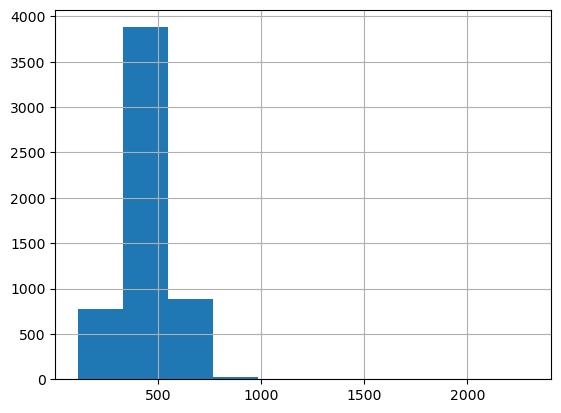

In [18]:
df["molWt"].hist()

* Or we can filter the data ... and get some statistics on the values

In [19]:
df=df[df['molWt']<900]
df.describe()

,pIC50,active,molWt
count,5556.000000,5556.000000,5556.000000
mean,6.657723,0.585493,442.611796
std,1.404325,0.492681,104.790575
min,1.602060,0.000000,110.112000
25%,5.563045,0.000000,368.407250
50%,6.698970,1.000000,443.508500
75%,7.721246,1.000000,514.001000
max,11.522879,1.000000,883.792000


## Task 3: Similarity search

Calculate the similarity between the compounds and a selected known inhibitor (e.g. Gefitinib) using a **circular fingerprint** and the **Tanimoto similarity** metric. 

Helpful talktorial: [T004-Compound similarity](https://projects.volkamerlab.org/teachopencadd/talktorials/T004_compound_similarity.html)

### 3.1. Select query compound

FDA approved EGFR inhibitor Gefitinib: `COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1`

In [20]:
gefitinib = Chem.MolFromSmiles("COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1")

### 3.2. Let's define a function that can do the job ...

In [28]:
def get_dataframe_with_x_most_similar_compounds_to_query(query, mol_df, molCol='molecule', x=10):
    query_fp = GetMorganFingerprintAsBitVect(query,2)
    mol_df['similarity'] = mol_df['morgan'].map(lambda x:DataStructs.TanimotoSimilarity(query_fp, x))
    mol_df.sort_values(['similarity'], ascending=False, inplace=True)
    return mol_df[:x]

### 3.2. Now we call the function ...

In [29]:
sim_df = get_dataframe_with_x_most_similar_compounds_to_query(gefitinib, df)

/var/folders/x4/lmdggv1j4979s5x0zkhx0q9m0000gp/T/ipykernel_59625/2027552174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mol_df['similarity'] = mol_df['morgan'].map(lambda x:DataStructs.TanimotoSimilarity(query_fp, x))
/var/folders/x4/lmdggv1j4979s5x0zkhx0q9m0000gp/T/ipykernel_59625/2027552174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mol_df.sort_values(['similarity'], ascending=False, inplace=True)


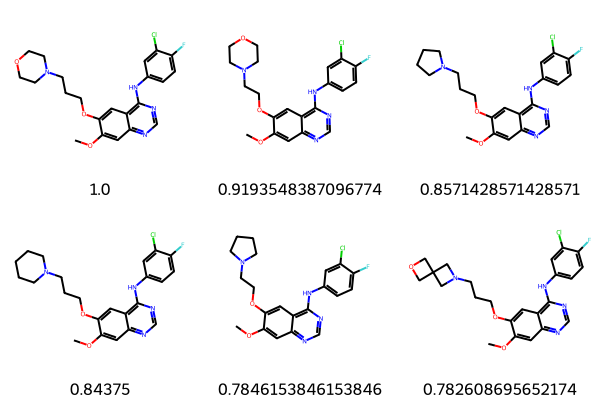

In [24]:
PandasTools.FrameToGridImage(sim_df.head(6), column='molecule', legendsCol='similarity')

## Task 4: Cluster compounds

* Cluster your compounds using Butina clustering with Tanimoto **dis**similarity as distance metric.
    * Calculate distance matrix
    * Do Butina clustering

Helpful talktorial: [T005-Compound clustering](https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html) 

Define a function to calculate distance matrix

In [30]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list (0 and len +1)
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

Prepare data for clustering

In [31]:
# Fingerprints as lists
fingerprints=df["morgan"].to_list()
# Calculate distance matrix
dist_matrix = tanimoto_distance_matrix(fingerprints)
# Define distance cut-off
cutoff=0.7

Cluster the data with the implemented Butina algorithm

In [32]:
clusters = Butina.ClusterData(dist_matrix, len(fingerprints), cutoff, isDistData=True)

Sort the clusters by size

In [33]:
clusters = sorted(clusters, key=len, reverse=True)

In [34]:
# Molecules as list
mols = df["molecule"].to_list()

In [48]:
# 278 clusters, each cluster has around 1-1000 mols
len(clusters), len(clusters[39])

(278, 20)

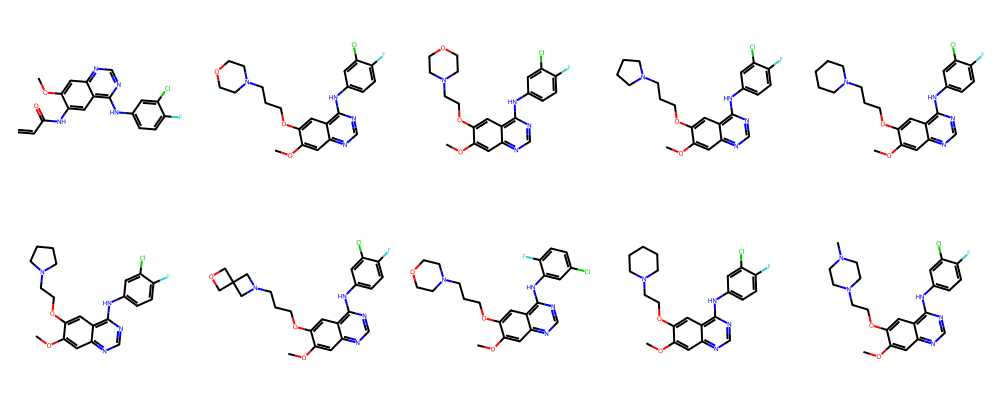

In [35]:
# Draw molecules
Draw.MolsToGridImage(
    [mols[i] for i in clusters[0][:10]],
    molsPerRow=5,
)

## Task 5: Maximum common substructure

[*if time allows*]

Identify and highlight the maximum common substructure (MCS) within a cluster.

Helpful talktorial: [T006-Maximum common substructures](https://projects.volkamerlab.org/teachopencadd/talktorials/T006_compound_maximum_common_substructures.html)

* Get moleculesfrom first cluster

In [37]:
subset = [mols[i] for i in clusters[0][:10]]

* Find MCS within subset

In [38]:
mcs = rdFMCS.FindMCS(subset)

In [49]:
print("MCS SMARTS string:", mcs.smartsString)

MCS SMARTS string: [#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6](:[#6]:3)-[#17]):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]


* Draw substructure from Smarts

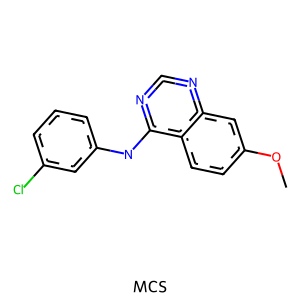

In [50]:
mol_pattern = Chem.MolFromSmarts(mcs.smartsString)
Draw.MolToImage(mol_pattern, legend="MCS")